In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from custom_utils import encode_texts, decode_ids, compute_bleu
from model_structure import Seq2Seq

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from datasets import load_from_disk
import json

# from google.colab import drive

# drive.mount("/content/drive")

dataset = load_from_disk("SlimOrca_Dedup_English_Uzbek_preprocessed")

split_dataset = dataset.train_test_split(test_size=64, seed=0, shuffle=True)

train_set = split_dataset["train"]
val_set = split_dataset["test"]

uz_encode_vocab = json.load(open("uz_encoding_vocab.json", "r"))

uz_decode_vocab = json.load(open("uz_decoding_vocab.json", "r"))
uz_decode_vocab = {int(k): v for k, v in uz_decode_vocab.items()}

en_encode_vocab = json.load(open("en_encoding_vocab.json", "r"))

en_decode_vocab = json.load(open("en_decoding_vocab.json", "r"))
en_decode_vocab = {int(k): v for k, v in en_decode_vocab.items()}


val_inp = val_set["translations"]
val_out = val_set["value"]

val_inp_ids, val_inp_mask = encode_texts(val_inp, uz_encode_vocab, decoder_input=False, device=device)

In [3]:
def compute_loss(model, input_tokens, output_tokens, input_mask, output_mask):
    logits = model(input_tokens, output_tokens, input_mask) # (batch_size, seq_len - 1, output_vocab_size)

    output = output_tokens[:, 1:]  # Skip the first token (usually <bos>)

    output_mask = output_mask.clone()
    output_mask = output_mask[:, 1:]  # Adjust mask to match the output sequence
    last_indices = output_mask.argmax(dim=-1)  # (batch_size,)
    output_mask[torch.arange(output_mask.shape[0]), last_indices] = 0

    logits_softmax = -F.log_softmax(logits, dim=-1)  # (batch_size, seq_len - 1, output_vocab_size)
    losses = logits_softmax.gather(dim=-1, index=output.unsqueeze(-1)).squeeze(-1)  # (batch_size, seq_len - 1)
    losses = losses.masked_fill(output_mask == 1, 0)
    final_loss = losses.sum() / (output_mask == 0).sum()
    return final_loss

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
import math

uz2en_model = Seq2Seq(
    input_vocab_size=len(uz_encode_vocab),
    output_vocab_size=len(en_encode_vocab),
    emb_dim=1000,
    hid_size=1000,
).to(device)

optimizer = torch.optim.Adam(uz2en_model.parameters(), lr=1e-3)
epochs = 10
batch_size = 128
train_size = 50000

num_of_batches = math.ceil(train_size / batch_size)
metrics = {"train_loss": [], "dev_bleu": []}

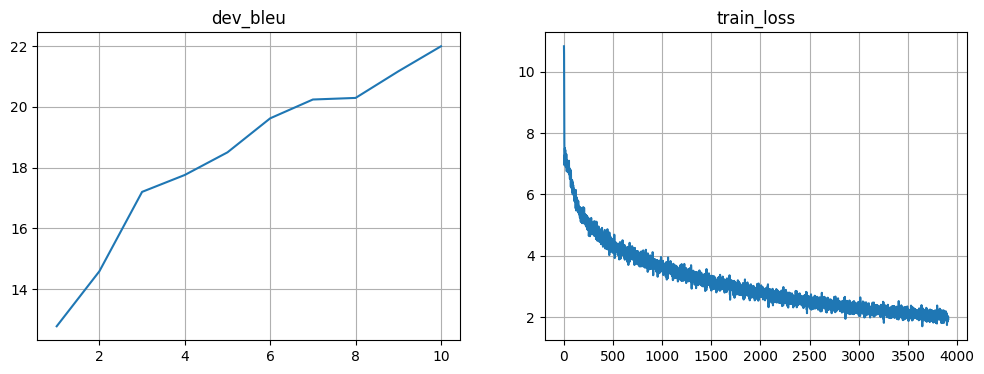

Mean loss=2.064


In [ ]:
for epoch in range(epochs):

    uz2en_model.train()
    iteration = 0

    for i in tqdm(range(0, train_size, batch_size)):
        input_batch = train_set[i : i + batch_size]["translations"]
        output_batch = train_set[i : i + batch_size]["value"]

        input_tokens, input_mask = encode_texts(input_batch, uz_encode_vocab, decoder_input=False, device=device)
        output_tokens, output_mask = encode_texts(output_batch, en_encode_vocab, decoder_input=True, device=device)

        optimizer.zero_grad()
        loss = compute_loss(uz2en_model, input_tokens, output_tokens, input_mask, output_mask)
        loss.backward()
        optimizer.step()

        iteration += 1

        metrics["train_loss"].append((iteration + num_of_batches * epoch, loss.item()))

    output_ids, _ = uz2en_model.translate(val_inp_ids, val_inp_mask, max_len=50)
    output_texts = decode_ids(output_ids, en_decode_vocab, en_encode_vocab["<eos>"])
    metrics['dev_bleu'].append((epoch + 1, compute_bleu(val_out, output_texts)))

    clear_output(True)
    plt.figure(figsize=(12, 4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()

    print("Mean loss=%.3f" % np.mean(metrics["train_loss"][-iteration:], axis=0)[1], flush=True)

In [ ]:
torch.save(uz2en_model.state_dict(), "/content/drive/MyDrive/NMT_Seq2Seq/uz2en_lstm_model_weights_50k.pth")

In [5]:
uz2en_model = Seq2Seq(
    input_vocab_size=len(uz_encode_vocab),
    output_vocab_size=len(en_encode_vocab),
    emb_dim=1000,
    hid_size=1000,
).to(device)

uz2en_model.load_state_dict(torch.load("uz2en_lstm_model_weights_50k.pth", map_location=device))

<All keys matched successfully>

In [7]:
total = sum(p.numel() for p in uz2en_model.parameters())
print("Total parameters:", total)

trainable = sum(p.numel() for p in uz2en_model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable)

Total parameters: 172076003
Trainable parameters: 172076003


In [8]:
en2uz_model = Seq2Seq(
    input_vocab_size=len(en_encode_vocab),
    output_vocab_size=len(uz_encode_vocab),
    emb_dim=1000,
    hid_size=1000,
).to(device)

en2uz_model.input_embedding.weight.data = uz2en_model.output_embedding.weight.data
en2uz_model.output_embedding.weight.data = uz2en_model.input_embedding.weight.data

en2uz_model.input_embedding.weight.requires_grad = False
en2uz_model.output_embedding.weight.requires_grad = False

In [9]:
val_inp = val_set["value"]
val_out = val_set["translations"]

val_inp_ids, val_inp_mask = encode_texts(val_inp, en_encode_vocab, decoder_input=False, device=device)

In [13]:
from tqdm import tqdm
from IPython.display import clear_output
import math

optimizer = torch.optim.Adam(en2uz_model.parameters(), lr=1e-3)
epochs = 10
batch_size = 128
train_size = 50000

num_of_batches = math.ceil(train_size / batch_size)
metrics = {"train_loss": [], "dev_bleu": []}

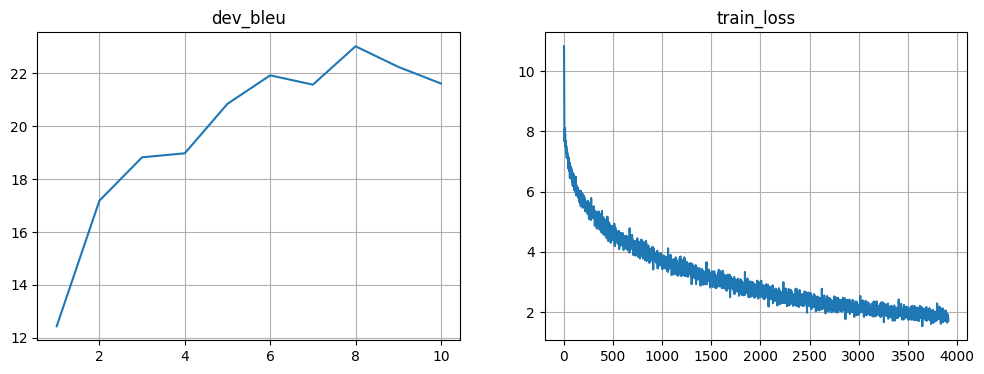

Mean loss=1.906


In [ ]:
for epoch in range(epochs):

    en2uz_model.train()
    iteration = 0

    for i in tqdm(range(0, train_size, batch_size)):
        input_batch = train_set[i : i + batch_size]["value"]
        output_batch = train_set[i : i + batch_size]["translations"]

        input_tokens, input_mask = encode_texts(input_batch, en_encode_vocab, decoder_input=False, device=device)
        output_tokens, output_mask = encode_texts(output_batch, uz_encode_vocab, decoder_input=True, device=device)

        optimizer.zero_grad()
        loss = compute_loss(en2uz_model, input_tokens, output_tokens, input_mask, output_mask)
        loss.backward()
        optimizer.step()

        iteration += 1

        metrics["train_loss"].append((iteration + num_of_batches * epoch, loss.item()))

    output_ids, _ = en2uz_model.translate(val_inp_ids, val_inp_mask, max_len=50)
    output_texts = decode_ids(output_ids, uz_decode_vocab, uz_encode_vocab["<eos>"])
    metrics['dev_bleu'].append((epoch + 1, compute_bleu(val_out, output_texts)))

    clear_output(True)
    plt.figure(figsize=(12, 4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()

    print("Mean loss=%.3f" % np.mean(metrics["train_loss"][-iteration:], axis=0)[1], flush=True)

In [15]:
torch.save(en2uz_model.state_dict(), "/content/drive/MyDrive/NMT_Seq2Seq/en2uz_lstm_model_weights_50k.pth")

In [16]:
en2uz_model = Seq2Seq(
    input_vocab_size=len(en_encode_vocab),
    output_vocab_size=len(uz_encode_vocab),
    emb_dim=1000,
    hid_size=1000,
).to(device)

en2uz_model.load_state_dict(torch.load("/content/drive/MyDrive/NMT_Seq2Seq/en2uz_lstm_model_weights_50k.pth", map_location=device))

<All keys matched successfully>

In [17]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(attn_weights, batch_order, input_text, output_text):
    """An intentionally ambiguous function to visualize attention weights"""
    input_text += " <eos>"
    output_text += " <eos>"

    inp_tokens = input_text.lower().split()
    trans_tokens = output_text.lower().split()

    probs = attn_weights[batch_order, : len(trans_tokens), -len(inp_tokens):]
    probs = probs[:, ::-1]

    fig = pl.figure(
        x_range=(0, len(inp_tokens)),
        y_range=(0, len(trans_tokens)),
        x_axis_type=None,
        y_axis_type=None,
        tools=[],
    )
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label="source tokens"), "above")
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(
        zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens)
    )
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label="translation tokens"), "left")
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(
        zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1])
    )

    show(fig)

In [19]:
import pandas as pd

en_text = val_set['value']
uz_text = val_set['translations']

input_ids, input_mask = encode_texts(en_text, en_encode_vocab, decoder_input=False, device=device)
output_ids, attn_weights = en2uz_model.translate(input_ids, input_mask, max_len=50)
output_texts = decode_ids(output_ids, uz_decode_vocab, uz_encode_vocab["<eos>"])

attn_weights = attn_weights.cpu().numpy() if isinstance(attn_weights, torch.Tensor) else attn_weights

sample_translations = {
    'English sentence': [],
    'Model translation': [],
    'True translation': []
}

for i in range(len(en_text)):
    sample_translations["English sentence"].append(en_text[i])
    sample_translations["Model translation"].append(output_texts[i])
    sample_translations["True translation"].append(uz_text[i])
    draw_attention(attn_weights, i, en_text[i], output_texts[i])

translation_df = pd.DataFrame(sample_translations)
translation_df.to_csv("/content/drive/MyDrive/NMT_Seq2Seq/en2uz_sample_translations.csv", index=False)